# MultiModel LLM(MLLM LLaVA) Chatbot




**A Brief Description of the LLaVA LMM Chatbot**

LLaVA is a end-to-end trained large multi-modal (LMM) model which combines the CLIP visual encoder with the Vicuna open source chatbot to create a general purpose multi-modal chatbot. Users interact with LLaVA by inputting both an image and a text prompt containing a set of instructions. LLaVA will then analyze the input image according to the instructions and output text describing the contents of the image.

**LLaVA Model Architecture and Training**

LLaVA creates and end-to-end multi-modal chatbot by simply combining a vision encoder with a language model. In theory any vision encoder and language model should work, as long as steps are taken to project the vision encoder’s tokens to the language model’s token space.


LLaVA combines a vision encoder with a language model to create an end-to-end general purpose multi-modal chatbot. Image taken from https://arxiv.org/pdf/2304.08485.pdf.

As shown in the image below, users interact with LLaVA by inputting an image and a text prompt containing instructions. The text prompt is tokenized directly by the language model’s tokenizer, while the image is first tokenized by the vision encoder, and the resulting tokens are then projected to the language model’s space.

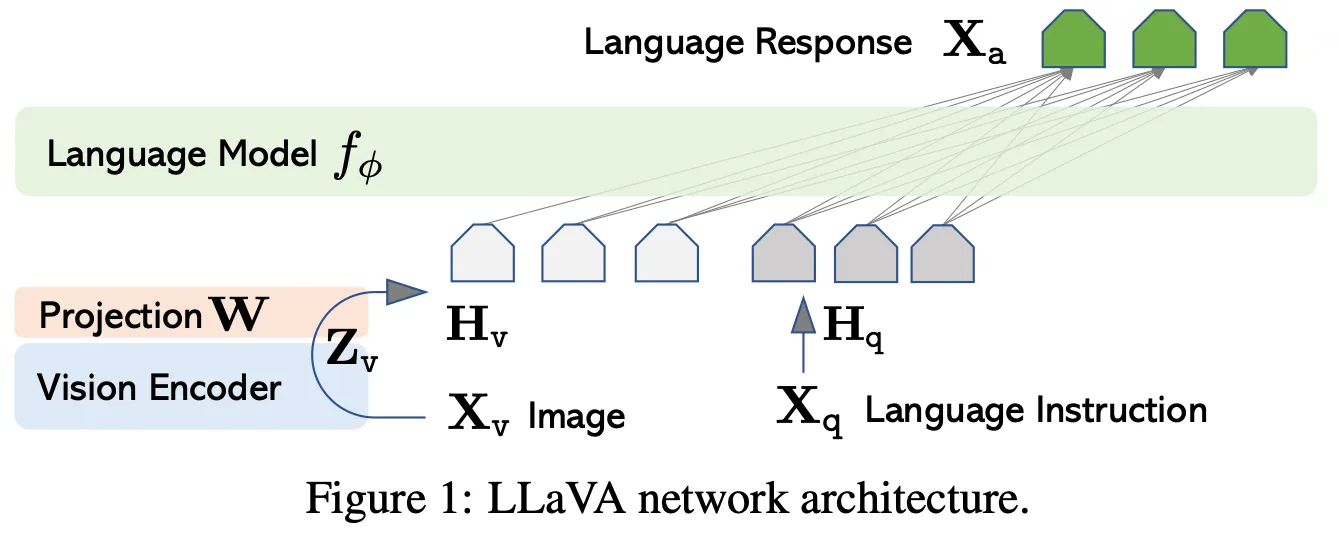

**LMM Business Use Cases**

As with LLMs such as ChatGPT, we can expect LMMs such as LLaVA to transform the way businesses operate. In this section we provide some plausible business ideas involving LLMs such as LLaVA.

Educational material is filled with both images and text. We can expect LMMs to further make quality of life improvements for both teaching staff and students. For example, LLMs can be used as a study tool by students to further improve their visual reasoning skills.

Security currently makes full use of computer vision models such as object detection and tracking to monitor CCTV camera footage. These models however are extremely limited in functionality. LMMs will be able to improve security processes by generating reports of security incidents using security footage.

Social tech can help visually impaired who are unable to fully process the world around them better navigate the world. With LMMs such as LLaVA loaded onto a smart device such as a smartphone, social tech companies can develop navigation apps and services to help the visually impaired better navigate and explore the world independently!


Documents, social media and news sites are filled with graphics and images. While LLMs are already used to digest and summarize the contents of documents, they are unable to process images. LMMs are able to, and will provide a major capability update to allow businesses to fully analyze both textual and visual contents.

# **MLLM Codes**

This notebook shows how to create a chatbot with the [multimodal LLaVA model](https://llava-vl.github.io/).

The notebook is divided in two parts:

- Load a LLaVA model and make it generate an answer from an image and a prompt

- Create a LLaVA chatbot interface using Gradio

The notebook can be run using Google Colab and a T4 TPU.


## Setting up environment

We rely on

- the transformers, bitsandbytes and accelerate libraries for loading/running the LLaVA model
- the gradio library for creating the Web chatbot interface

Note: if you get the bug 'A UTF-8 locale is required. Got ANSI_X3.4-1968', try running the following code:

```
import locale
locale.getpreferredencoding = lambda: "UTF-8"
```

In [1]:
# !pip install -q transformers==4.36.0
# !pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
# !pip install -q gradio==4.14.0

!pip install -q transformers
!pip install -q bitsandbytes accelerate
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 410.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/1

In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

## Load the LLaVA model

The model is loaded from its [HuggingFace repository](https://huggingface.co/llava-hf/llava-1.5-7b-hf), using the transformers' `pipeline` object.

Let us quantize it in 4bits to reduce the GPU memory consumption.

In [2]:
from transformers import pipeline, BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 13B version can be loaded with llava-hf/llava-1.5-13b-hf
model_id = "llava-hf/llava-1.5-7b-hf"


pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

### Test LLaVA model

Let us load the following image (Image by <a href="https://pixabay.com/users/grey48-7109111/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3116211">Guy Rey-Bellet</a> from <a href="https://pixabay.com//?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3116211">Pixabay</a>)

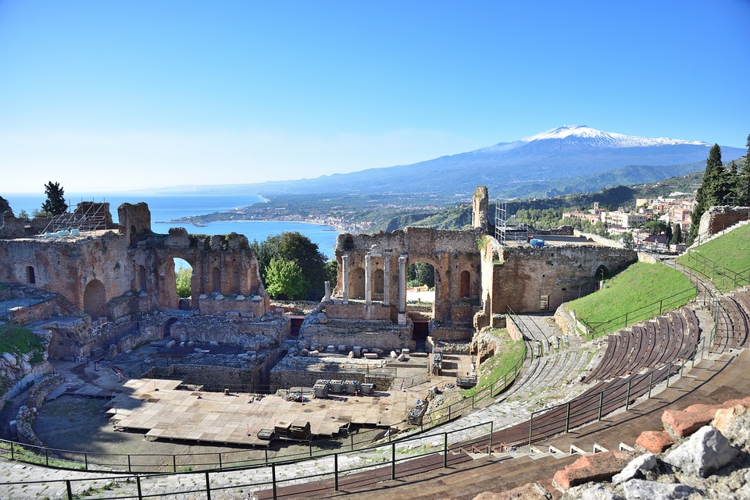

In [ ]:
import requests
from PIL import Image

image_url = "https://cdn.pixabay.com/photo/2018/01/29/14/13/italy-3116211_960_720.jpg"

image = Image.open(requests.get(image_url, stream=True).raw).resize((750,500))
image

In [ ]:
prompt = "USER: <image>\nDescribe this picture\n​ASSISTANT: "

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
print(outputs[0]['generated_text'])

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


USER:  
Describe this picture
​ASSISTANT: ​The image features a large, old-fashioned theater with a stone facade. The theater is situated next to a body of water, providing a picturesque backdrop. The theater has a large seating area, with numerous chairs spread throughout the venue.

In the background, there is a majestic mountain, adding to the scenic beauty of the location. The theater appears to be empty, with no people visible in the scene. The overall atmosphere of the theater suggests a sense of history and architectural significance.


## Create a LLaVA chatbot with Gradio


In [3]:
def update_conversation(new_message, history, image):

    if image is None:
        return "Please upload an image first using the widget on the left"

    conversation_starting_from_image = [[user, assistant] for [user, assistant] in history if not assistant.startswith('Please')]

    prompt = "USER: <image>\n"

    for i in range(len(history)):
        prompt+=history[i][0]+'\nASSISTANT: '+history[i][1]+"\nUSER: "

    prompt = prompt+new_message+'\nASSISTANT: '

    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200
                                                          #, "do_sample" : True,
                                                          #"temperature" : 0.7
                                                          })[0]['generated_text']

    return outputs[len(prompt)-6:]


In [4]:
import gradio as gr

with gr.Blocks() as demo:

    with gr.Row():
      image = gr.Image(type='pil', interactive=True)

      gr.ChatInterface(
          update_conversation, additional_inputs=[image]
      )

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a81391865076765526.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a81391865076765526.gradio.live


Related notebooks:

- Loading LLaVA in 4bits with colab: https://colab.research.google.com/drive/1qsl6cd2c8gGtEW1xV5io7S8NHh-Cp1TV?usp=sharing (from official transformers library at https://huggingface.co/docs/transformers/model_doc/llava)

